### KMeans 를 이용한 붓꽃 분류

In [5]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# 붓꽃 데이터 로드하기
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df.rename(columns={'sepal length (cm)':'sepal length', 'sepal width (cm)':'sepal width', 'petal length (cm)':'petal length', 'petal width (cm)':'petal width'}, inplace=True)

# 3개의 그룹으로 군집화하는 K-Means 객체 생성 후 군집화 학습
kmeans = KMeans(n_clusters=3, random_state=11)
kmeans.fit(iris_df)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",11
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [6]:
# 군집화된 클러스터의 중앙값
print('군집화된 클러스터의 중앙값 : ', kmeans.cluster_centers_)

# KMeans 군집 예측값
print('KMeans 군집 예측값 : ', kmeans.labels_)

군집화된 클러스터의 중앙값 :  [[5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]
 [6.85384615 3.07692308 5.71538462 2.05384615]]
KMeans 군집 예측값 :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [7]:
# 실제 분류값인 target과 군집화 분류값인 labels_(cluster)를 이용하여 비교 확인
iris_df['target'] = iris.target
iris_df['cluster'] = kmeans.labels_
iris_result = iris_df.groupby(by=['target','cluster']).size()
print(iris_result)

target  cluster
0       0          50
1       1          47
        2           3
2       1          14
        2          36
dtype: int64


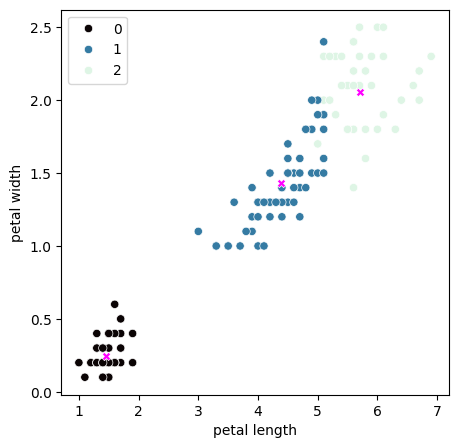

In [8]:
# 군집화 결과 시각화
import seaborn as sns

plt.figure(figsize=(5,5))
sns.scatterplot(data = iris_df, x='petal length', y='petal width', hue='cluster', palette='mako')
sns.scatterplot(x=kmeans.cluster_centers_[:,2], y=kmeans.cluster_centers_[:,3], color='magenta', marker='X')
plt.show()

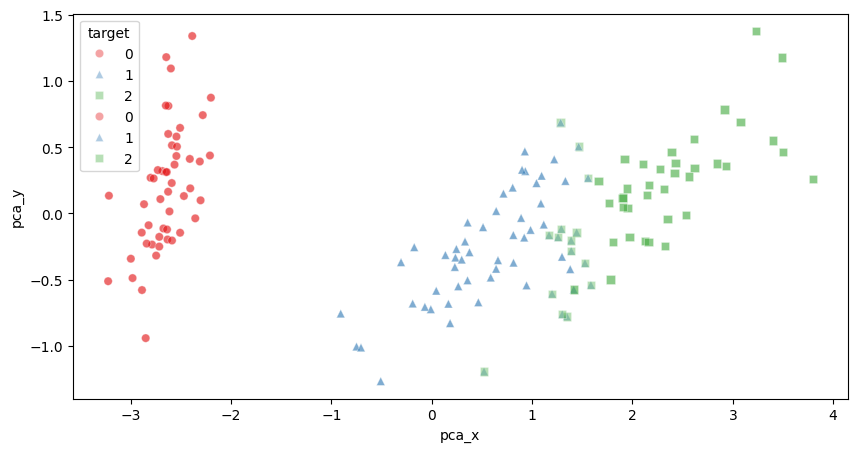

In [9]:
# PCA 를 이용해 4개의 속성을 2개로 차원 축소한 뒤에 X 좌표, Y 좌표로 개별 데이터를 표현
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

# 데이터프레임에 두 속성 추가
iris_df['pca_x'] = pca_transformed[:,0]
iris_df['pca_y'] = pca_transformed[:,1]

# PCA로 차원 축소된 데이터를 시각화 (산점도)
plt.figure(figsize=(10,5))
sns.scatterplot(data=iris_df, x='pca_x', y='pca_y', hue='cluster', palette='Set1', style='cluster', markers=['o','^','s'], alpha=0.4)
sns.scatterplot(data=iris_df, x='pca_x', y='pca_y', hue='target', palette='Set1', style='target', markers=['o','^','s'], alpha=0.4)
plt.show()

### silhouette_samples 로 실루엣 계수값 구하기

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score

# 변형되지 않은 원본 데이터로 다시 load()
iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data=iris.data, columns=feature_names)

# KMeans 군집화를 위한 객체 생성 후 학습
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11).fit(iris_df)

iris_df['cluster'] = kmeans.labels_

# iris 의 모든 개별 데이터에 실루엣 계수값을 구함.
score_samples = silhouette_samples(iris.data, iris_df['cluster'])

# irisDF에 실루엣 계수 컬럼 추가
iris_df['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함.
average_score = silhouette_score(iris.data, iris_df['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

iris_df.head(3)

붓꽃 데이터셋 Silhouette Analysis Score:0.551


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,0,0.852582
1,4.9,3.0,1.4,0.2,0,0.814916
2,4.7,3.2,1.3,0.2,0,0.828797


In [11]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

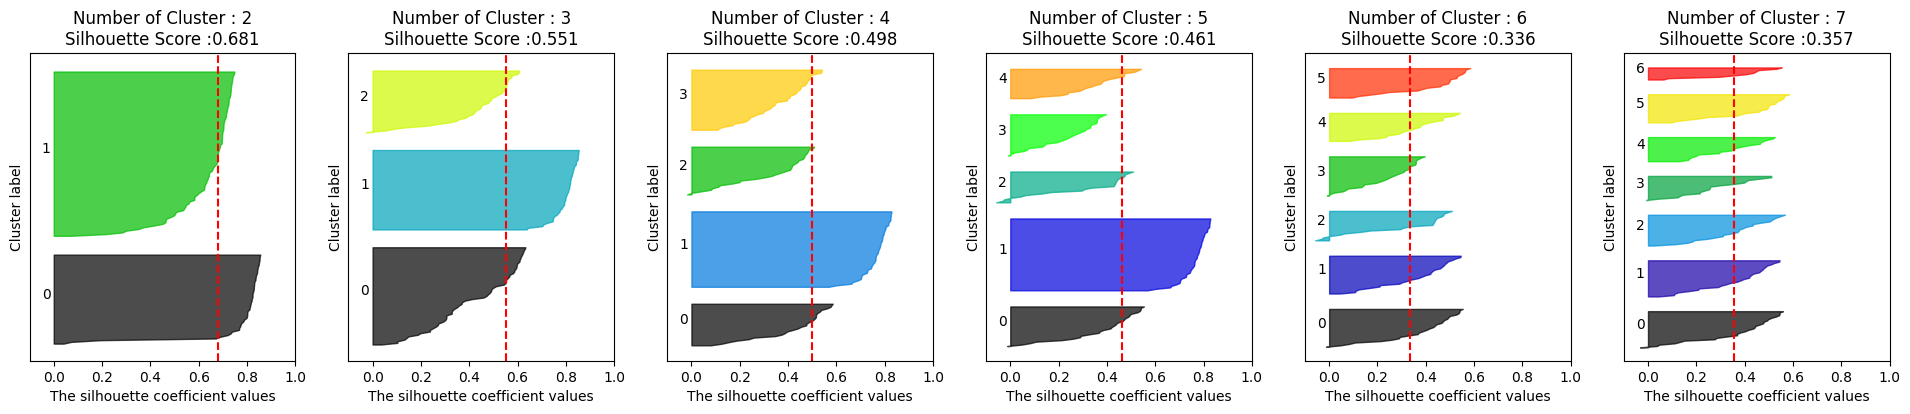

In [13]:
import numpy as np

# 붓꽃 데이터를 이용해 K-평균 수행 시 최적의 군집 개수를 알아보기
iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
visualize_silhouette([ 2, 3, 4, 5, 6, 7], iris_df)

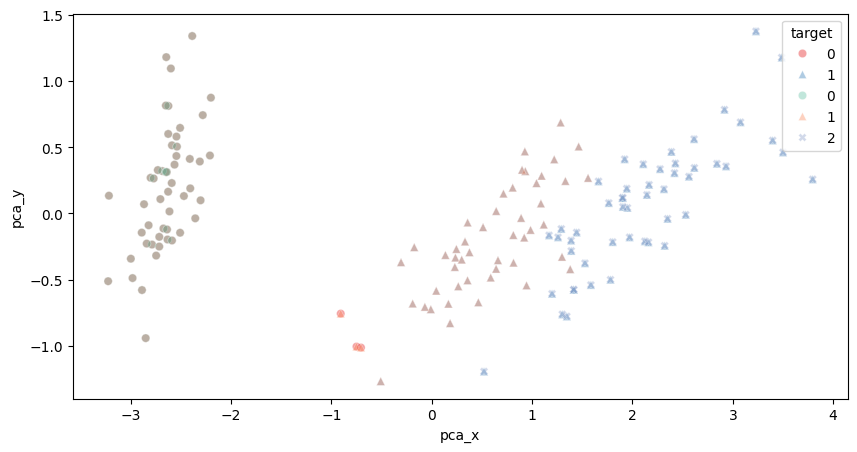

In [14]:
# cluster 군집을 2개로 변경하여 분석
kmeans = KMeans(n_clusters=2, random_state=11)
kmeans.fit(iris_df)

iris_df['target'] = iris.target
iris_df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

# 데이터프레임에 두 속성 추가
iris_df['pca_x'] = pca_transformed[:,0]
iris_df['pca_y'] = pca_transformed[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(data=iris_df, x='pca_x', y='pca_y', hue='cluster', palette='Set1', style='cluster', markers=['o','^'], alpha=0.4)
sns.scatterplot(data=iris_df, x='pca_x', y='pca_y', hue='target', palette='Set2', style='target', markers=['o','^', 'X'], alpha=0.4)
plt.show()

### Elbow Method

Text(0.5, 1.0, 'Elbow Method')

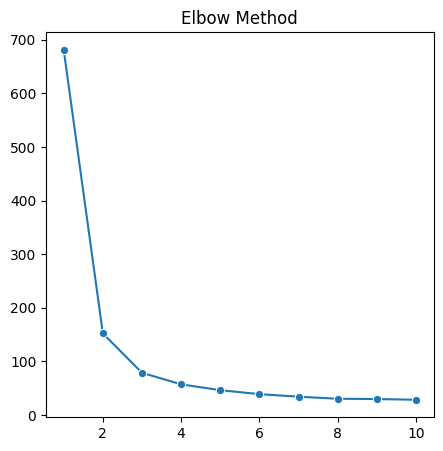

In [16]:
inertia = []
for n in range(1, 11):
    km = KMeans(n_clusters=n, random_state=42) # random_state 고정
    km.fit(iris.data)
    inertia.append(km.inertia_)

plt.figure(figsize=(5,5))
sns.lineplot(x=[t for t in range(1, 11)], y=inertia, marker='o')
plt.title('Elbow Method')